## Teste Behavior Learning

In [1]:
import time
from dm_control import suite
from dm_control.suite.wrappers import pixels
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from torch.utils.data import DataLoader
from replay_buffer import ReplayBuffer
from actor_critic import ActionModel, ValueNet
from general_algo import collect_replay_buffer
from auxiliares import converter_cinza, training_device
from train_wm import DreamerWorldModel  # Importa sua implementação do DreamerWorldModel
from behavior_learning import extract_latent_sequences, create_latent_dataset, behavior_learning  # Ajuste o nome do módulo se necessário

# Parâmetros e dispositivo
S = 5  # Número de episódios a coletar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cria o ambiente
env = suite.load(domain_name="cartpole", task_name="swingup")
env = pixels.Wrapper(env, pixels_only=True,
                        render_kwargs={'height': 84, 'width': 84, 'camera_id': 0})

replay_buffer = collect_replay_buffer(env,S,ReplayBuffer())

# Instancia o world_model, ator e value_net
input_size = None  # Não utilizado pelo autoencoder
latent_dim = 256
action_dim = np.prod(env.action_spec().shape)
hidden_dim = 256

world_model = DreamerWorldModel(input_size, latent_dim, action_dim, hidden_dim).to(device)
actor = ActionModel(latent_dim, action_dim).to(device)
value_net = ValueNet(latent_dim).to(device)

# Extrai sequências latentes usando o world_model treinado
latent_buffer = extract_latent_sequences(world_model, replay_buffer, device)

# Cria o dataset latente e o DataLoader
latent_dataset = create_latent_dataset(latent_buffer)
latent_loader = DataLoader(latent_dataset, batch_size=1000, shuffle=True)

# Define otimizadores e função de perda
actor_optimizer = optim.Adam(actor.parameters(), lr=8e-5)
value_optimizer = optim.Adam(value_net.parameters(), lr=8e-5)
mse_loss = nn.MSELoss()

# Executa o Behavior Learning com rollouts imaginados
epochs_behavior = 100
actor, value_net, actor_loss_history, value_loss_history = behavior_learning(
    world_model, actor, value_net,
    latent_loader,
    device,
    horizon=15,
    gamma=0.99,
    lam=0.95,
    value_optimizer=value_optimizer,
    actor_optimizer=actor_optimizer,
    mse_loss=mse_loss,
    epochs_behavior=epochs_behavior
)

print("Behavior learning test completed.")


Collected 5 episodes.
[Behavior] Epoch 1/100 | Value Loss: 0.5667 | Actor Loss: 0.0662
[Behavior] Epoch 2/100 | Value Loss: 0.5720 | Actor Loss: 0.1371
[Behavior] Epoch 3/100 | Value Loss: 0.5653 | Actor Loss: 0.2113
[Behavior] Epoch 4/100 | Value Loss: 0.5506 | Actor Loss: 0.2897
[Behavior] Epoch 5/100 | Value Loss: 0.5503 | Actor Loss: 0.3791
[Behavior] Epoch 6/100 | Value Loss: 0.5736 | Actor Loss: 0.4829
[Behavior] Epoch 7/100 | Value Loss: 0.5790 | Actor Loss: 0.6029
[Behavior] Epoch 8/100 | Value Loss: 0.5991 | Actor Loss: 0.7457
[Behavior] Epoch 9/100 | Value Loss: 0.6023 | Actor Loss: 0.9146
[Behavior] Epoch 10/100 | Value Loss: 0.6456 | Actor Loss: 1.1084
[Behavior] Epoch 11/100 | Value Loss: 0.6612 | Actor Loss: 1.3286
[Behavior] Epoch 12/100 | Value Loss: 0.6998 | Actor Loss: 1.5756
[Behavior] Epoch 13/100 | Value Loss: 0.7410 | Actor Loss: 1.8517
[Behavior] Epoch 14/100 | Value Loss: 0.7340 | Actor Loss: 2.1446
[Behavior] Epoch 15/100 | Value Loss: 0.7070 | Actor Loss: 2.45

## Teste wandb

In [1]:
import time
import wandb

# Inicializa o wandb
wandb.init(project="teste_custom_steps", name="teste_custom_steps_run")

# Define as métricas com seus step_metrics personalizados
wandb.define_metric("Reward/Episode", step_metric="global_step", summary="max")
wandb.define_metric("Inner/Metric", step_metric="inner_step", step_sync=True)

global_step = 0  # Contador para o loop externo
inner_step = 0   # Contador para o loop interno

for i in range(5):
    global_step += 1
    # Simula um valor de reward para o loop externo
    reward = global_step * 40

    # No loop interno simulamos um contador com granularidade diferente
    inner_step += 10  # Por exemplo, a cada iteração do loop externo, o inner_step aumenta em 3
    inner_metric = inner_step * 0.5  # Valor dummy para inner_metric

    # Registra ambas as métricas em uma única chamada, incluindo seus respectivos steps
    wandb.log({
        "Reward/Episode": reward,
        "global_step": global_step,
        "Inner/Metric": inner_metric,
        "inner_step": inner_step
    }, step=global_step)  # Aqui o step passado é o global_step

    print(f"Global step {global_step}: Reward = {reward} | Inner step {inner_step}: Inner Metric = {inner_metric}")

wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: marcospaulo2 (marcospaulo2-federal-university-of-goi-s) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Global step 1: Reward = 40 | Inner step 10: Inner Metric = 5.0
Global step 2: Reward = 80 | Inner step 20: Inner Metric = 10.0
Global step 3: Reward = 120 | Inner step 30: Inner Metric = 15.0
Global step 4: Reward = 160 | Inner step 40: Inner Metric = 20.0
Global step 5: Reward = 200 | Inner step 50: Inner Metric = 25.0


Inner/Metric,▁▃▅▆█
Reward/Episode,▁▃▅▆█
global_step,▁▃▅▆█
inner_step,▁▃▅▆█
Inner/Metric,25
global_step,5
inner_step,50


In [6]:
pip freeze


absl-py==2.1.0
annotated-types==0.7.0
appnope @ file:///home/conda/feedstock_root/build_artifacts/appnope_1733332318622/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
astunparse==1.6.3
attrs==25.1.0
certifi==2025.1.31
charset-normalizer==3.4.1
click==8.1.8
cloudpickle==3.1.1
cmake==3.31.4
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1733502965406/work
contourpy==1.3.1
cycler==0.12.1
debugpy @ file:///Users/runner/miniforge3/conda-bld/debugpy_1737269774354/work
decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1733236420667/work
dm-env==1.6
dm-tree==0.1.9
dm_control==1.0.27
docker-pycreds==0.4.0
etils==1.12.0
exceptiongroup @ file:///home/conda/feedstock_root/build_artifacts/exceptiongroup_1733208806608/work
executing @ file:///home/conda/feedstock_root/build_artifacts/executing_1733569351617/work
Farama-Notifications==0.0.4
filelock==3.17.0
flatbuffers==25.2.10
fonttools==4.56.0
fsspec==2025.2.0
gas

## Teste render deepmind control

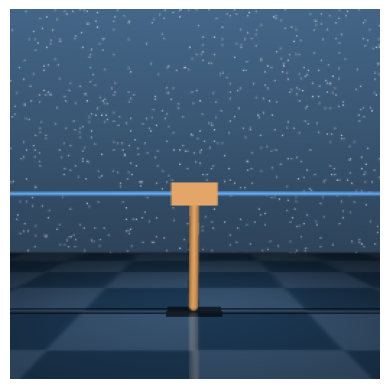

In [1]:
import matplotlib.pyplot as plt
from dm_control import suite
from dm_control.suite.wrappers import pixels

# Define as dimensões desejadas para a renderização
HEIGHT = 256
WIDTH = 256

# Carrega o ambiente "cartpole" com a tarefa "swingup"
env = suite.load(domain_name="cartpole", task_name="swingup")

# Envolve o ambiente para retornar apenas imagens (pixels)
env = pixels.Wrapper(env, pixels_only=False,
                     render_kwargs={'height': HEIGHT, 'width': WIDTH, 'camera_id': 0})

# Reseta o ambiente e obtém o estado inicial
time_step = env.reset()

# A imagem está na observação com a chave 'pixels'
image = time_step.observation['pixels']

# Exibe a imagem usando o matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()
